### In this notebook we are gonna scale all input rows and then we are gonna train a model with the scaled data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# read data from csv, utf-8 encoding
df = pd.read_csv('../data/data_v2.csv', encoding='utf-8')

In [4]:
df.head()

,Unnamed: 0,amount,amount.1,createdAt,recipient_accountNumber,recipient_full_name,sender_full_name,reviewed,reported
0,0,476.860,425.200,2023-09-14,3b681d83ccee97f33b3e,Stephen Small,Stephen Small,False,False
1,1,700.000,714.800,2023-09-14,22386743d148e118584d,Matthew Gilbert,Matthew Gilbert,False,False
2,2,30.000,31.140,2023-09-14,e2c2800b47b605016ee8,Peter Watkins,Peter Watkins,False,False
3,3,550.000,629.660,2023-09-14,4937ff8c2964230a207d,Cindy Larson,Patricia Brown,False,False
4,4,2285.250,2052.090,2023-09-14,2d3d71ee832ada40ce63,Patricia Ford,Patricia Ford,False,False


In [5]:
# df.drop(['Unnamed: 0', 'amount.1'], axis=1, inplace=True)
# df.rename(columns={'recipient.fake_accountNumber': 'recipient_accNumber', 'recipient.fake_name': 'recipient_name', 
#                    'sender.fake_name': 'sender', 'fake_amount': 'amount'}, inplace=True)
df.rename(columns={'tx_amount': 'amount'}, inplace=True)

In [6]:
print(df['reported'].value_counts())
print(df['reported'].value_counts(normalize=True))

False    74047
True      1396
Name: reported, dtype: int64
False   0.981
True    0.019
Name: reported, dtype: float64


## Feature Engineering

In [7]:
df['day'] = pd.to_datetime(df['createdAt']).dt.day
df['month'] = pd.to_datetime(df['createdAt']).dt.month
df['year'] = pd.to_datetime(df['createdAt']).dt.year
df['weekofyear'] = pd.to_datetime(df['createdAt']).dt.isocalendar().week
df['is_weekend'] = pd.to_datetime(df['createdAt']).dt.dayofweek.apply(lambda x: 1 if x > 4 else 0)
df['day_of_week'] = pd.to_datetime(df['createdAt']).dt.dayofweek
df['quarter'] = pd.to_datetime(df['createdAt']).dt.quarter

In [8]:
df['daily_tx_count_of_recipient'] = df.groupby(['recipient_full_name', 'day', 'month'])['amount'].transform('count')
df['daily_tx_count_of_sender'] = df.groupby(['sender_full_name', 'day', 'month'])['amount'].transform('count')
df['daily_tx_count_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'day', 'month'])['amount'].transform('count')

df['weekly_tx_count_of_recipient'] = df.groupby(['recipient_full_name', 'weekofyear'])['amount'].transform('count')
df['weekly_tx_count_of_sender'] = df.groupby(['sender_full_name', 'weekofyear'])['amount'].transform('count')
df['weekly_tx_count_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'weekofyear'])['amount'].transform('count')

df['monthly_tx_count_of_recipient'] = df.groupby(['recipient_full_name', 'month'])['amount'].transform('count')
df['monthly_tx_count_of_sender'] = df.groupby(['sender_full_name', 'month'])['amount'].transform('count')
df['monthly_tx_count_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'month'])['amount'].transform('count')

In [9]:
df['log_amount'] = df['amount'].apply(lambda x: np.log(x))
df['scaled_amount'] = StandardScaler().fit_transform(df['amount'].values.reshape(-1, 1))

In [10]:
# recipient accounts per recipient name
df['recipient_acc_per_recipient_name'] = df.groupby(['recipient_full_name'])['recipient_accountNumber'].transform('nunique')
# senders per recipient name
df['sender_per_recipient_name'] = df.groupby(['recipient_full_name'])['sender_full_name'].transform('nunique')

In [11]:
# weekly tx amount of recipient
df['weekly_tx_amount_of_recipient'] = df.groupby(['recipient_full_name', 'weekofyear'])['amount'].transform('sum')
# weekly tx amount of sender
df['weekly_tx_amount_of_sender'] = df.groupby(['sender_full_name', 'weekofyear'])['amount'].transform('sum')
# weekly tx amount of recipient account number
df['weekly_tx_amount_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'weekofyear'])['amount'].transform('sum')


# monthly tx amount of recipient
df['monthly_tx_amount_of_recipient'] = df.groupby(['recipient_full_name', 'month'])['amount'].transform('sum')
# monthly tx amount of sender
df['monthly_tx_amount_of_sender'] = df.groupby(['sender_full_name', 'month'])['amount'].transform('sum')
# monthly tx amount of recipient account number
df['monthly_tx_amount_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'month'])['amount'].transform('sum')

# daily tx amount of recipient
df['daily_tx_amount_of_recipient'] = df.groupby(['recipient_full_name', 'day'])['amount'].transform('sum')
# daily tx amount of sender
df['daily_tx_amount_of_sender'] = df.groupby(['sender_full_name', 'day'])['amount'].transform('sum')
# daily tx amount of recipient account number
df['daily_tx_amount_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'day'])['amount'].transform('sum')

In [12]:
# weekly average tx amount of recipient
df['weekly_average_tx_amount_of_recipient'] = df.groupby(['recipient_full_name', 'weekofyear'])['amount'].transform('mean')
# weekly average tx amount of sender
df['weekly_average_tx_amount_of_sender'] = df.groupby(['sender_full_name', 'weekofyear'])['amount'].transform('mean')
# weekly average tx amount of recipient account number
df['weekly_average_tx_amount_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'weekofyear'])['amount'].transform('mean')

# monthly average tx amount of recipient
df['monthly_average_tx_amount_of_recipient'] = df.groupby(['recipient_full_name', 'month'])['amount'].transform('mean')
# monthly average tx amount of sender
df['monthly_average_tx_amount_of_sender'] = df.groupby(['sender_full_name', 'month'])['amount'].transform('mean')
# monthly average tx amount of recipient account number
df['monthly_average_tx_amount_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'month'])['amount'].transform('mean')

# daily average tx amount of recipient
df['daily_average_tx_amount_of_recipient'] = df.groupby(['recipient_full_name', 'day'])['amount'].transform('mean')
# daily average tx amount of sender
df['daily_average_tx_amount_of_sender'] = df.groupby(['sender_full_name', 'day'])['amount'].transform('mean')
# daily average tx amount of recipient account number
df['daily_average_tx_amount_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'day'])['amount'].transform('mean')

In [13]:
# weekly average tx count of recipient
df['weekly_average_tx_count_of_recipient'] = df.groupby(['recipient_full_name', 'weekofyear'])['amount'].transform('count')
# weekly average tx count of sender
df['weekly_average_tx_count_of_sender'] = df.groupby(['sender_full_name', 'weekofyear'])['amount'].transform('count')
# weekly average tx count of recipient account number
df['weekly_average_tx_count_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'weekofyear'])['amount'].transform('count')

# monthly average tx count of recipient
df['monthly_average_tx_count_of_recipient'] = df.groupby(['recipient_full_name', 'month'])['amount'].transform('count')
# monthly average tx count of sender
df['monthly_average_tx_count_of_sender'] = df.groupby(['sender_full_name', 'month'])['amount'].transform('count')
# monthly average tx count of recipient account number
df['monthly_average_tx_count_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'month'])['amount'].transform('count')


# daily average tx count of recipient
df['daily_average_tx_count_of_recipient'] = df.groupby(['recipient_full_name', 'day'])['amount'].transform('count')
# daily average tx count of sender
df['daily_average_tx_count_of_sender'] = df.groupby(['sender_full_name', 'day'])['amount'].transform('count')
# daily average tx count of recipient account number
df['daily_average_tx_count_of_recipient_accNumber'] = df.groupby(['recipient_accountNumber', 'day'])['amount'].transform('count')

In [14]:
columns_to_be_scaled = [ 'amount', 'day', 'month', 'year', 'weekofyear', 'is_weekend', 'day_of_week', 'quarter', 'daily_tx_count_of_recipient', 'daily_tx_count_of_sender',
    'daily_tx_count_of_recipient_accNumber', 'weekly_tx_count_of_recipient', 'weekly_tx_count_of_sender', 'weekly_tx_count_of_recipient_accNumber',
    'monthly_tx_count_of_recipient', 'monthly_tx_count_of_sender', 'monthly_tx_count_of_recipient_accNumber','recipient_acc_per_recipient_name',
    'sender_per_recipient_name', 'weekly_tx_amount_of_recipient', 'weekly_tx_amount_of_sender', 'weekly_tx_amount_of_recipient_accNumber',
    'monthly_tx_amount_of_recipient', 'monthly_tx_amount_of_sender', 'monthly_tx_amount_of_recipient_accNumber','daily_tx_amount_of_recipient', 
    'daily_tx_amount_of_sender', 'daily_tx_amount_of_recipient_accNumber', 'weekly_average_tx_amount_of_recipient', 'weekly_average_tx_amount_of_sender',
    'weekly_average_tx_amount_of_recipient_accNumber', 'monthly_average_tx_amount_of_recipient', 'monthly_average_tx_amount_of_sender',
    'monthly_average_tx_amount_of_recipient_accNumber', 'daily_average_tx_amount_of_recipient', 'daily_average_tx_amount_of_sender',
    'daily_average_tx_amount_of_recipient_accNumber', 'weekly_average_tx_count_of_recipient', 'weekly_average_tx_count_of_sender',
    'weekly_average_tx_count_of_recipient_accNumber', 'monthly_average_tx_count_of_recipient', 'monthly_average_tx_count_of_sender',
    'monthly_average_tx_count_of_recipient_accNumber', 'daily_average_tx_count_of_recipient', 'daily_average_tx_count_of_sender',
    'daily_average_tx_count_of_recipient_accNumber']

In [15]:
scaled_columns_names = ['scaled_' + i for i in columns_to_be_scaled]

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = MinMaxScaler()

df[scaled_columns_names] = scaler.fit_transform(df[columns_to_be_scaled])

In [17]:
# scaled_df = df.copy()

# # scale the columns with MinMaxScaler
# scaler = MinMaxScaler()
# scaled_df[scaled_columns_names] = scaler.fit_transform(df[columns_to_be_scaled])

In [18]:
df[scaled_columns_names].head()

,scaled_amount,scaled_day,scaled_month,scaled_year,scaled_weekofyear,scaled_is_weekend,scaled_day_of_week,scaled_quarter,scaled_daily_tx_count_of_recipient,scaled_daily_tx_count_of_sender,...,scaled_daily_average_tx_amount_of_recipient_accNumber,scaled_weekly_average_tx_count_of_recipient,scaled_weekly_average_tx_count_of_sender,scaled_weekly_average_tx_count_of_recipient_accNumber,scaled_monthly_average_tx_count_of_recipient,scaled_monthly_average_tx_count_of_sender,scaled_monthly_average_tx_count_of_recipient_accNumber,scaled_daily_average_tx_count_of_recipient,scaled_daily_average_tx_count_of_sender,scaled_daily_average_tx_count_of_recipient_accNumber
0,0.000,0.433,1.000,0.000,1.000,0.000,0.500,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.433,1.000,0.000,1.000,0.000,0.500,1.000,0.000,0.000,...,0.000,0.016,0.016,0.000,0.012,0.012,0.000,0.000,0.000,0.000
2,0.000,0.433,1.000,0.000,1.000,0.000,0.500,1.000,0.000,0.000,...,0.000,0.016,0.016,0.016,0.006,0.006,0.006,0.000,0.000,0.000
3,0.000,0.433,1.000,0.000,1.000,0.000,0.500,1.000,0.000,0.000,...,0.000,0.016,0.016,0.016,0.018,0.018,0.018,0.000,0.000,0.000
4,0.001,0.433,1.000,0.000,1.000,0.000,0.500,1.000,0.000,0.000,...,0.001,0.000,0.000,0.000,0.006,0.006,0.006,0.000,0.000,0.000


In [19]:
# save as csv
df.to_csv('../data/custom_preprocess_v2_3.csv', index=False)

In [20]:
input_columns = scaled_columns_names
print(len(input_columns))

46


In [21]:
scaled_df = df.copy()

In [22]:
scaled_df[input_columns].head().T

,0,1,2,3,4
scaled_amount,0.000,0.000,0.000,0.000,0.001
scaled_day,0.433,0.433,0.433,0.433,0.433
scaled_month,1.000,1.000,1.000,1.000,1.000
scaled_year,0.000,0.000,0.000,0.000,0.000
scaled_weekofyear,1.000,1.000,1.000,1.000,1.000
scaled_is_weekend,0.000,0.000,0.000,0.000,0.000
scaled_day_of_week,0.500,0.500,0.500,0.500,0.500
scaled_quarter,1.000,1.000,1.000,1.000,1.000
scaled_daily_tx_count_of_recipient,0.000,0.000,0.000,0.000,0.000
scaled_daily_tx_count_of_sender,0.000,0.000,0.000,0.000,0.000


## Train 

In [23]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(46, 23),  # Encode_1: 48 -> 24
            nn.Tanh(),
            nn.Linear(23, 12),  # Encode_2: 24 -> 12
            nn.ReLU(),
            nn.Linear(12, 6),  # Encode_3: 12 -> 6
            nn.LeakyReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),  # Decode_1: 6 -> 12
            nn.Tanh(),
            nn.Linear(12, 23),  # Decode_2: 12 -> 24
            nn.ReLU(),
            nn.Linear(23, 46),  # Decode_3: 24 -> 48
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [24]:
df['reported'].replace({True: 1, False: 0}, inplace=True)

In [25]:
print(scaled_df['reported'].value_counts())

False    74047
True      1396
Name: reported, dtype: int64


In [26]:
sorted_df = scaled_df.sort_values(by=['reported'], ascending=False)

In [27]:
X = sorted_df[input_columns]
y = sorted_df['reported']

In [28]:
# sort by time 
sorted_df = scaled_df.sort_values(by=['createdAt'])

# train_size = int(len(scaled_df) * 0.75)

# do train test split 
from sklearn.model_selection import train_test_split

X = sorted_df[input_columns]
y = sorted_df['reported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y)


# train_data = sorted_df[input_columns].iloc[:train_size]
# test_data = sorted_df[input_columns].iloc[train_size:]
# train_df = sorted_df[:train_size]
# test_df = sorted_df[train_size:]

# train_labels = sorted_df['reported']
# test_labels = sorted_df['reported']

# Filter training data to only include normal transactions
# normal_train_data = train_data[train_labels == 0]  # Assuming 0 means normal

X_normal_train = X_train[y_train == 0]

In [29]:
print(y_test.value_counts(normalize=True))

False   0.981
True    0.019
Name: reported, dtype: float64


In [30]:
print(y_train.value_counts(normalize=True))

False   0.981
True    0.019
Name: reported, dtype: float64


In [34]:
from sklearn.model_selection import ParameterSampler

hyperparameters = {
    'learning_rate': [1e-3, 1e-4, 1e-6],
    'batch_size': [32, 64, 128],
    'num_epochs': [50, 100, 150, 300]
    # Add other hyperparameters if needed
}


n_iter_search = 10  # Number of iterations for random search

best_overall_loss = float('inf')
best_params = {}

loss_type = 'MSE'  # Choose between 'MSE' and 'BCE'
if loss_type == 'MSE':
    criterion = nn.MSELoss()  # Mean squared error loss
else:
    criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss. Use if you have a sigmoid activation in the output layer.

train_tensor = torch.tensor(X_normal_train.values, dtype=torch.float32)
test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

lambda_reg = 1e-3


for params in ParameterSampler(hyperparameters, n_iter=n_iter_search):
    print("Testing with parameters:", params)

    # Update hyperparameters
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']
    learning_rate = params['learning_rate']


     # DataLoader setup
    train_dataset = torch.utils.data.TensorDataset(train_tensor)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(test_tensor)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model and criterion setup
    model = Autoencoder()
    criterion = nn.MSELoss() if loss_type == 'MSE' else nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_reg)

    best_loss = float('inf')
    patience = 10
    epochs_without_improvement = 0

    loss_values = []
    test_loss_values = []
    reconstruction_errors = []

        
    for epoch in range(num_epochs):
        reconstruction_errors = []
        epoch_loss = 0.0
        for batch in train_dataloader:
            inputs = batch[0]

            # Zero the optimizer's gradient buffer
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            mse_loss = criterion(outputs, inputs)
            
            # 3. Activity Regularizer
            # Assuming the first layer of the encoder is model.encoder[0]
            activity_regularizer = lambda_reg * torch.norm(model.encoder[0](inputs), 1)
            
            # Combining the regularized loss
            total_loss = mse_loss + activity_regularizer

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()
        
        epoch_loss = epoch_loss / len(train_dataloader)

        # Save the loss value for plotting
        loss_values.append(epoch_loss)

        # Test the model
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            for batch in test_dataloader:
                inputs = batch[0]
                outputs = model(inputs)
                mse_loss = criterion(outputs, inputs)
                test_loss += mse_loss.item()

                batch_errors = torch.sum((outputs - inputs) ** 2, dim=1).numpy() # Sum of squared differences for each sample
                reconstruction_errors.extend(batch_errors)

            test_loss = test_loss / len(test_dataloader)
            test_loss_values.append(test_loss)

        model.train()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")


        # Early stopping check
        if epoch_loss + 1e-5 < best_loss:
            best_loss = epoch_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == patience:
            print("Early stopping due to no improvement in loss.")
            break
    
    # Evaluate and record the best performing hyperparameters
    if best_loss < best_overall_loss:
        best_overall_loss = best_loss
        best_params = params

print(f"Best overall loss: {best_overall_loss}")
print(f"Best hyperparameters: {best_params}")

    

Testing with parameters: {'num_epochs': 300, 'learning_rate': 1e-06, 'batch_size': 32}
Epoch [1/300], Train Loss: 0.1584, Test Loss: 0.0632
Epoch [2/300], Train Loss: 0.1525, Test Loss: 0.0614
Epoch [3/300], Train Loss: 0.1469, Test Loss: 0.0596
Epoch [4/300], Train Loss: 0.1415, Test Loss: 0.0580
Epoch [5/300], Train Loss: 0.1364, Test Loss: 0.0564
Epoch [6/300], Train Loss: 0.1314, Test Loss: 0.0550
Epoch [7/300], Train Loss: 0.1267, Test Loss: 0.0536
Epoch [8/300], Train Loss: 0.1221, Test Loss: 0.0522
Epoch [9/300], Train Loss: 0.1178, Test Loss: 0.0510
Epoch [10/300], Train Loss: 0.1137, Test Loss: 0.0498
Epoch [11/300], Train Loss: 0.1098, Test Loss: 0.0487
Epoch [12/300], Train Loss: 0.1062, Test Loss: 0.0476
Epoch [13/300], Train Loss: 0.1027, Test Loss: 0.0466
Epoch [14/300], Train Loss: 0.0995, Test Loss: 0.0456
Epoch [15/300], Train Loss: 0.0963, Test Loss: 0.0447
Epoch [16/300], Train Loss: 0.0933, Test Loss: 0.0439
Epoch [17/300], Train Loss: 0.0904, Test Loss: 0.0431
Epoc

Best overall loss: inf
Best hyperparameters: {}


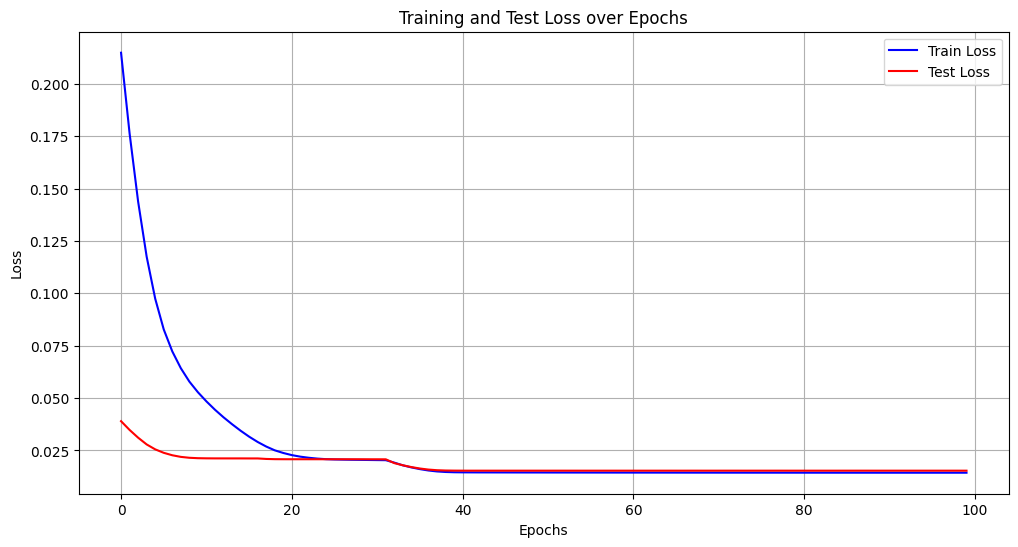

In [172]:
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(loss_values, label="Train Loss", color="blue")
plt.plot(test_loss_values, label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
# plt.savefig('../images/our_loss_plot.png')
plt.show()

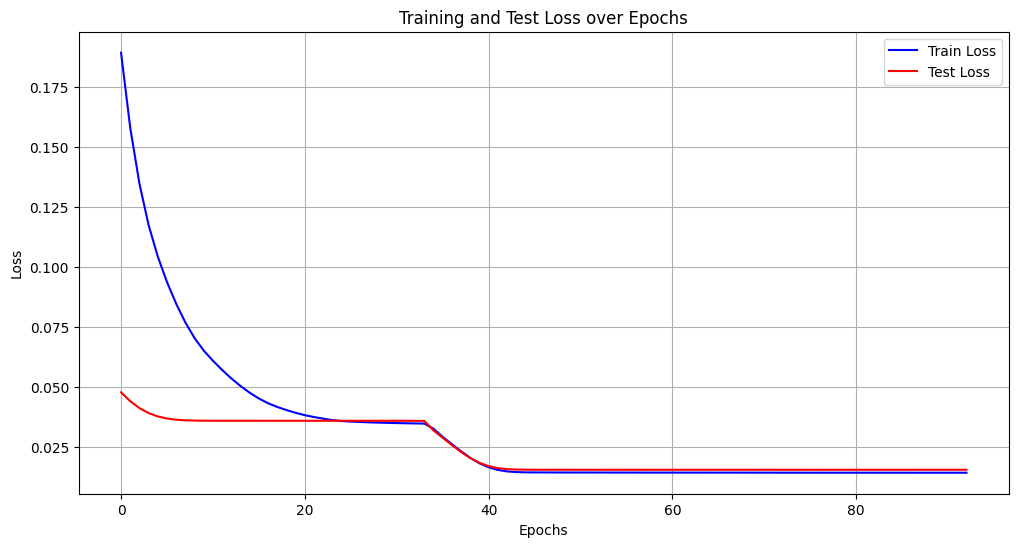

In [37]:
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(loss_values, label="Train Loss", color="blue")
plt.plot(test_loss_values, label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

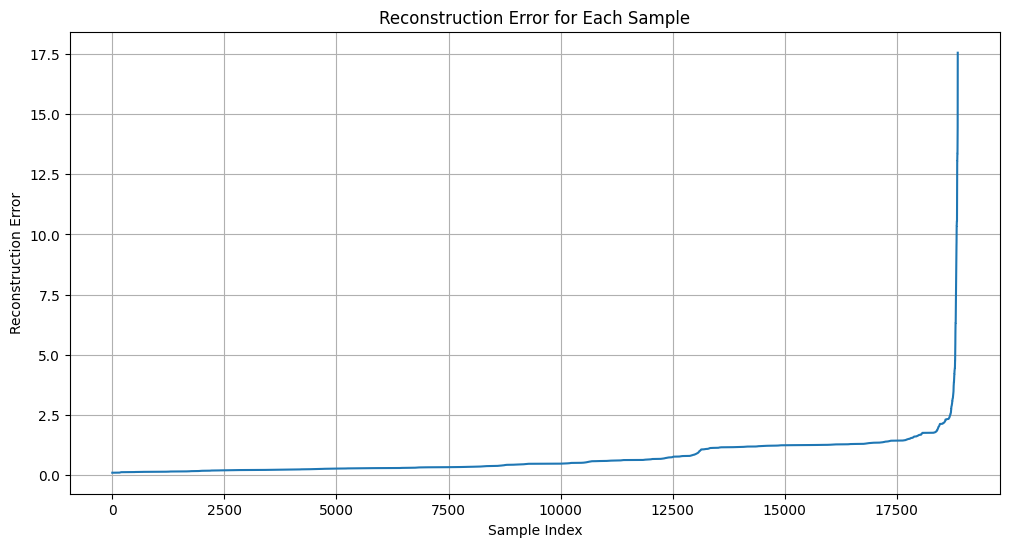

In [261]:
# sort and plot the reconstruction errors
reconstruction_errors.sort()
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors)
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error for Each Sample")
plt.grid(True)

## Evaluations

In [179]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve

# Reconstruct the test data
with torch.no_grad():
    reconstructed_test = model(test_tensor).numpy()

In [174]:
X_test.shape

(18861, 46)

In [184]:
reconstruction_errors.min()

0.002224842629845305

In [185]:
# Calculate reconstruction error
reconstruction_errors = np.mean(np.power(X_test - reconstructed_test, 2), axis=1)

# Choose a threshold based on domain knowledge, the distribution of reconstruction errors, or via a validation set.
threshold = np.percentile(reconstruction_errors, 99)  # e.g., 99th percentile as threshold. This is a naive approach; refine based on your needs.

# Convert reconstruction errors into binary labels (0 or 1)
predicted_labels = [1 if error > threshold else 0 for error in reconstruction_errors]

# Convert reconstruction errors into probabilities between 0 and 1
predicted_probabilities = (reconstruction_errors - reconstruction_errors.min()) / (reconstruction_errors.max() - reconstruction_errors.min())

# Assuming df has a 'reported' column with true labels
true_labels = scaled_df['reported'].loc[X_test.index].values

In [187]:
# Calculate metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Calculate FPR
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
fpr = fp / (fp + tn)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'False Positive Rate (FPR): {fpr:.4f}')

F1 Score: 0.4684
Precision: 0.6667
Recall: 0.3610
Accuracy: 0.9848
ROC AUC: 0.8013
False Positive Rate (FPR): 0.0034


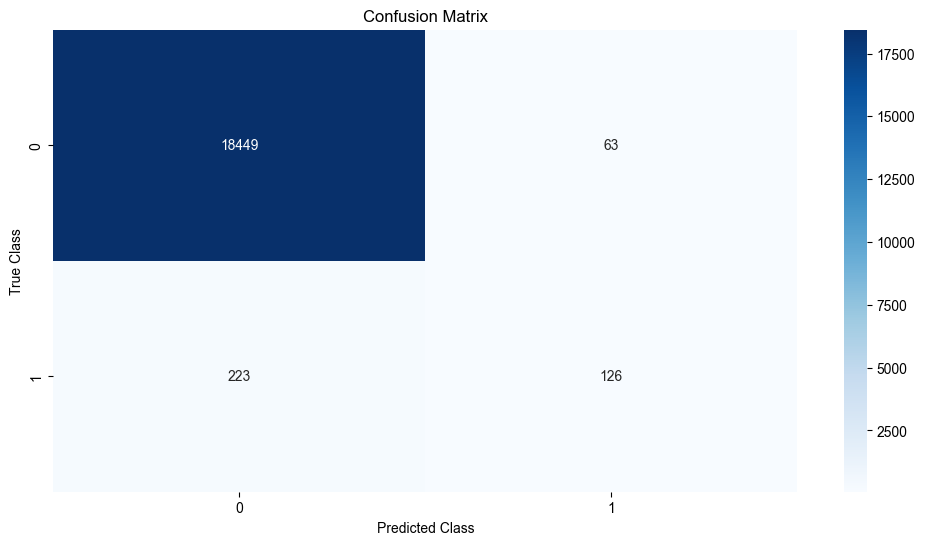

In [188]:
# heatmap of confusion matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
sns.set(font_scale=0.5)
plt.show()

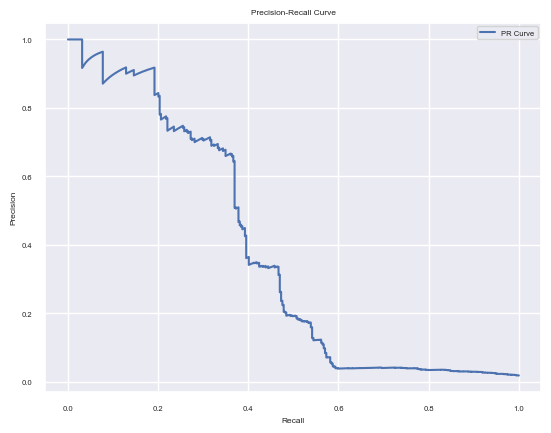

In [189]:
# 1. PR Curve
precision_vals, recall_vals, _ = precision_recall_curve(true_labels, predicted_probabilities)
plt.figure()
plt.plot(recall_vals, precision_vals, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

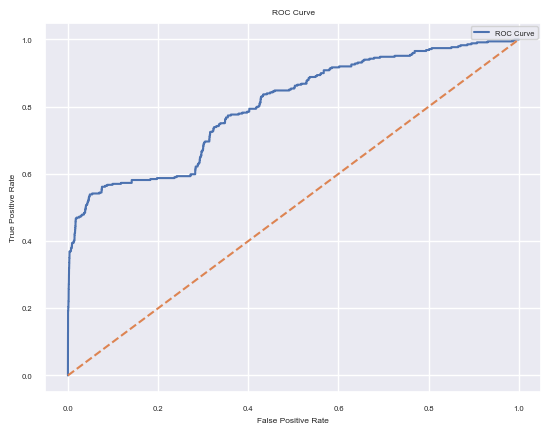

In [190]:
# 2. ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(true_labels, predicted_probabilities)
plt.figure()
plt.plot(fpr_vals, tpr_vals, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

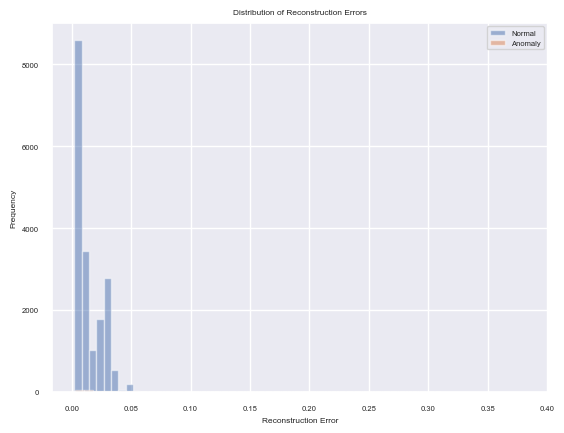

In [191]:
# 3. Distribution of Reconstruction Errors
plt.figure()
plt.hist(reconstruction_errors[true_labels == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(reconstruction_errors[true_labels == 1], bins=50, alpha=0.5, label='Anomaly')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

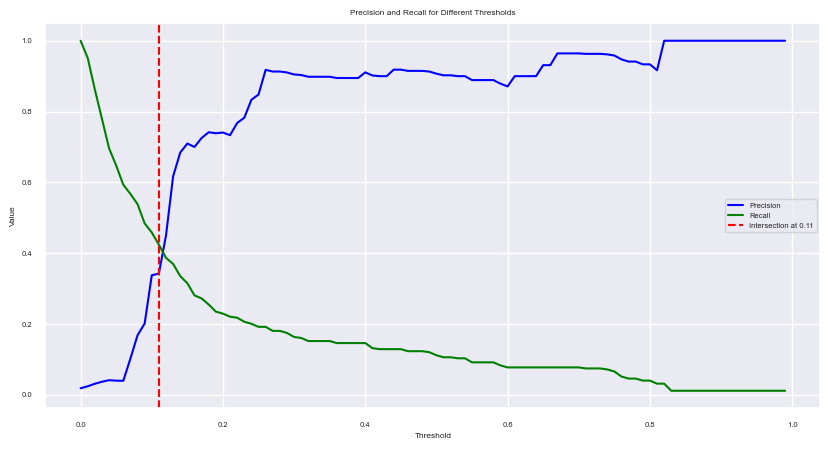

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming the other parts of your code, where you compute `predicted_probabilities` and `true_labels`, are above this

# List to store precision and recall values for each threshold
precisions = []
recalls = []

# Iterate over a range of thresholds (e.g., from 0 to 1 with a step of 0.01)
thresholds = np.arange(0, 1, 0.01)  # Adjust the range and step as needed

for threshold in thresholds:
    # Calculate predicted labels for this threshold
    predicted_labels_threshold = [1 if error > threshold else 0 for error in predicted_probabilities]
    
    # Avoiding a scenario where there's a perfect precision or recall which can cause "UndefinedMetricWarning"
    if len(np.unique(predicted_labels_threshold)) > 1:
        # Compute precision and recall
        precision = precision_score(true_labels, predicted_labels_threshold)
        recall = recall_score(true_labels, predicted_labels_threshold)
    else:
        precision, recall = 0, 0

    precisions.append(precision)
    recalls.append(recall)

# Find the threshold where precision and recall cross
diffs = np.array(precisions) - np.array(recalls)
cross_points = np.where(np.diff(np.sign(diffs)))[0]  # Where the difference changes sign

# Plot
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')

# If there's an intersection point, plot it
if len(cross_points) > 0:
    cross_threshold = thresholds[cross_points[0]]
    plt.axvline(x=cross_threshold, color='red', linestyle='--', label=f'Intersection at {cross_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall for Different Thresholds')
plt.legend()
plt.grid(True)
# plt.savefig('../images/our_precision_recall_plot.png')
plt.show()


In [195]:
if len(cross_points) > 0:
    cross_threshold = thresholds[cross_points[0]]

    # Use the cross_threshold to convert predicted_probabilities into binary labels
    predicted_labels_cross_threshold = [1 if prob > cross_threshold else 0 for prob in predicted_probabilities]

    # Calculate metrics
    f1 = f1_score(true_labels, predicted_labels_cross_threshold)
    precision = precision_score(true_labels, predicted_labels_cross_threshold)
    recall = recall_score(true_labels, predicted_labels_cross_threshold)
    accuracy = accuracy_score(true_labels, predicted_labels_cross_threshold)
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)

    # Calculate FPR
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels_cross_threshold).ravel()
    fpr = fp / (fp + tn)

    # Print out the metrics
    print(f'\nMetrics for threshold = {cross_threshold:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'False Positive Rate (FPR): {fpr:.4f}')


Metrics for threshold = 0.1100
F1 Score: 0.3790
Precision: 0.3426
Recall: 0.4241
Accuracy: 0.9743
ROC AUC: 0.8013
False Positive Rate (FPR): 0.0153


In [49]:
if len(cross_points) > 0:
    cross_threshold = thresholds[cross_points[0]]

    # Use the cross_threshold to convert predicted_probabilities into binary labels
    predicted_labels_cross_threshold = [1 if prob > cross_threshold else 0 for prob in predicted_probabilities]

    # Calculate metrics
    f1 = f1_score(true_labels, predicted_labels_cross_threshold)
    precision = precision_score(true_labels, predicted_labels_cross_threshold)
    recall = recall_score(true_labels, predicted_labels_cross_threshold)
    accuracy = accuracy_score(true_labels, predicted_labels_cross_threshold)
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)

    # Calculate FPR
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels_cross_threshold).ravel()
    fpr = fp / (fp + tn)

    # Print out the metrics
    print(f'\nMetrics for threshold = {cross_threshold:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'False Positive Rate (FPR): {fpr:.4f}')


Metrics for threshold = 0.1100
F1 Score: 0.4231
Precision: 0.3707
Recall: 0.4928
Accuracy: 0.9751
ROC AUC: 0.8437
False Positive Rate (FPR): 0.0158


In [ ]:
max_error

0.3814604285870234

### Different method where threshold is reconstruction error

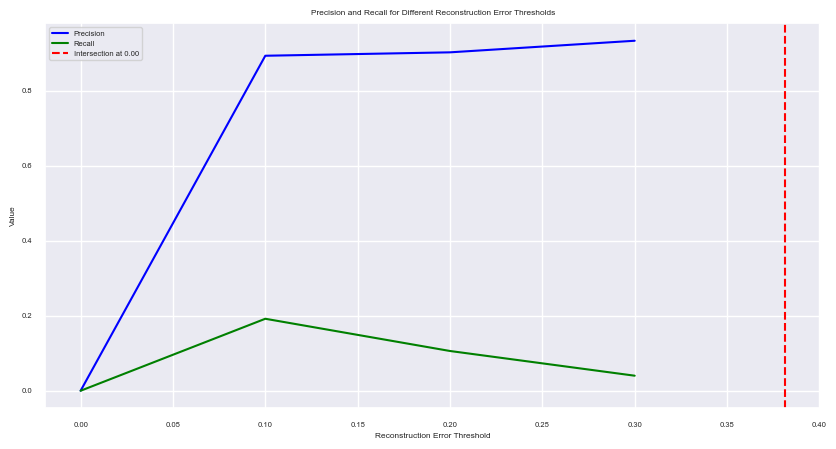

In [200]:
max_error = np.max(reconstruction_errors)
thresholds = np.arange(0, max_error, 0.1)

precisions = []
recalls = []


# Iterate over the defined range of thresholds
for threshold in thresholds:
    predicted_labels_threshold = [1 if error > threshold else 0 for error in reconstruction_errors]

    if len(np.unique(predicted_labels_threshold)) > 1:
        precision = precision_score(true_labels, predicted_labels_threshold)
        recall = recall_score(true_labels, predicted_labels_threshold)
    else:
        precision, recall = 0, 0

    precisions.append(precision)
    recalls.append(recall)

# Find the threshold where precision and recall cross
diffs = np.array(precisions) - np.array(recalls)
cross_points = np.where(np.diff(np.sign(diffs)))[0]

# Plotting
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')

if len(cross_points) > 0:
    # cross_threshold = thresholds[cross_points[0]]
    plt.axvline(x=max_error, color='red', linestyle='--', label=f'Intersection at {cross_threshold:.2f}')

plt.xlabel('Reconstruction Error Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall for Different Reconstruction Error Thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# normal_train_data
normal_train_tensor = torch.tensor(normal_train_data.values, dtype=torch.float32)
with torch.no_grad():
    reconstructed_normal_train = model(normal_train_tensor).numpy()
normal_reconstruction_errors = np.mean(np.power(normal_train_data - reconstructed_normal_train, 2), axis=1)

# to dataframe
normal_reconstruction_errors_df = pd.DataFrame(normal_reconstruction_errors, columns=['reconstruction_error'])

In [54]:
normal_reconstruction_errors.describe()

count   55535.000
mean        0.014
std         0.012
min         0.002
25%         0.005
50%         0.007
75%         0.026
max         0.320
dtype: float64

In [273]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
scaled_amount,36124.000,0.001,0.005,0.000,0.000,0.000,0.000,0.309
scaled_day,36124.000,0.504,0.296,0.000,0.233,0.500,0.733,1.000
scaled_month,36124.000,0.949,0.087,0.800,0.800,1.000,1.000,1.000
scaled_year,36124.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
scaled_weekofyear,36124.000,0.910,0.060,0.783,0.870,0.913,0.957,1.000
scaled_is_weekend,36124.000,0.193,0.395,0.000,0.000,0.000,0.000,1.000
scaled_day_of_week,36124.000,0.436,0.323,0.000,0.167,0.333,0.667,1.000
scaled_quarter,36124.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
scaled_daily_tx_count_of_recipient,36124.000,0.007,0.049,0.000,0.000,0.000,0.000,1.000
scaled_daily_tx_count_of_sender,36124.000,0.010,0.074,0.000,0.000,0.000,0.000,1.000


In [44]:
# calculate test mse on negative labels
normal_test_data = test_data[test_labels == 0]  # Assuming 0 means normal
normal_test_tensor = torch.tensor(normal_test_data.values, dtype=torch.float32)
with torch.no_grad():
    reconstructed_normal_test = model(normal_test_tensor).numpy()
normal_reconstruction_errors = np.mean(np.power(normal_test_data - reconstructed_normal_test, 2), axis=1)
# to dataframe
normal_reconstruction_errors = pd.DataFrame(normal_reconstruction_errors, columns=['reconstruction_error'])

/var/folders/l0/myv4vn5x1tq6rttc145y03180000gn/T/ipykernel_15976/3641302468.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  normal_test_data = test_data[test_labels == 0]  # Assuming 0 means normal


In [45]:
normal_reconstruction_errors.describe()

,reconstruction_error
count,18512.000
mean,0.022
std,0.010
min,0.008
25%,0.014
50%,0.020
75%,0.023
max,0.242


In [46]:
normal_reconstruction_errors['reconstruction_error'].sort_values(ascending=False).head(10)

# show top 1% of reconstruction errors
threshold = np.percentile(normal_reconstruction_errors['reconstruction_error'], 95)  # e.g., 99th percentile as threshold. This is a naive approach; refine based on your needs.
normal_reconstruction_errors[normal_reconstruction_errors['reconstruction_error'] > threshold].sort_values(by=['reconstruction_error'], ascending=False)

,reconstruction_error
10451,0.242
18358,0.072
18485,0.072
18513,0.072
18357,0.072
...,...
8732,0.045
9671,0.045
9387,0.045
8652,0.045


In [56]:
# calculate mse between test data and reconstructed test data
test_reconstruction_errors = np.mean(np.power(test_data - reconstructed_test, 2), axis=1)
# to dataframe
test_reconstruction_errors = pd.DataFrame(test_reconstruction_errors)
test_reconstruction_errors.describe()

,0
count,18861.000
mean,0.017
std,0.013
min,0.005
25%,0.010
50%,0.014
75%,0.017
max,0.236


In [58]:
test_reconstruction_errors.max()

0   0.236
dtype: float64

In [48]:
min = test_reconstruction_errors.describe().loc['min'][0]

In [141]:
# rules of thumb to identify the number of bins Freedman-Diaconis rule
# q1 = normal_reconstruction_errors.quantile(0.25)[0]
# q3 = normal_reconstruction_errors.quantile(0.75)[0]
min = test_reconstruction_errors.quantile(0.008)
max = test_reconstruction_errors.quantile(0.242)
iqr = max - min
bin_width = 2 * iqr / len(normal_reconstruction_errors) ** (1 / 3)
bin_count = int(np.ceil( (normal_reconstruction_errors.max()[0] - normal_reconstruction_errors.min()[0]) / bin_width))

IndexError: invalid index to scalar variable.

Text(0.5, 1.0, 'bins - 500')

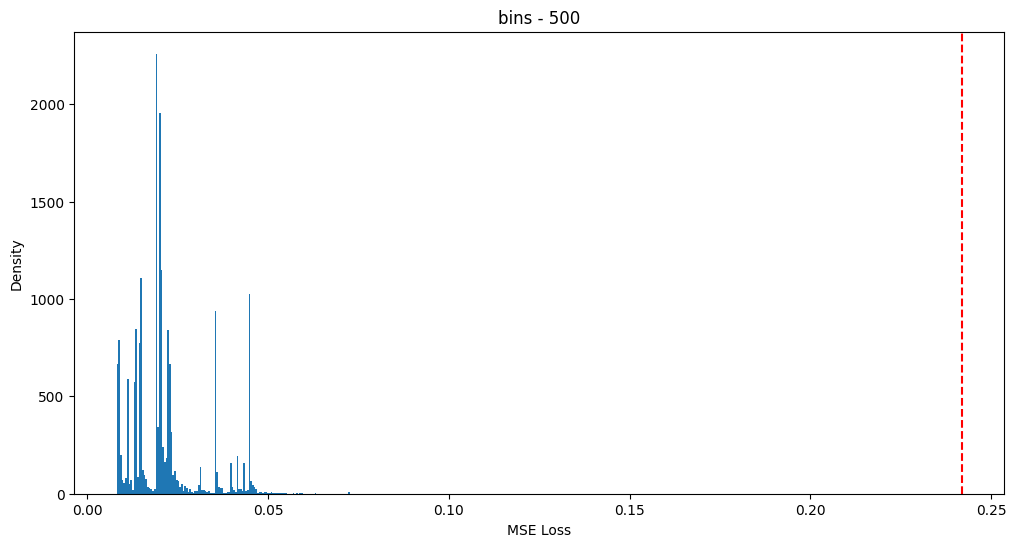

In [51]:
fig = plt.figure(figsize=(12, 6))
plt.hist(normal_reconstruction_errors, bins=bin_count)
plt.axvline(x=normal_reconstruction_errors.max()[0], color='red', linestyle='--', label=f'Normal Threshold at {normal_reconstruction_errors.max()[0]:.2f}')
plt.xlabel("MSE Loss")
plt.ylabel("Density")
plt.title(f'bins - {bin_count}')

In [64]:
normal_reconstruction_errors.max()

0.31958846666173046

In [65]:
max = normal_reconstruction_errors.max()

F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9810
ROC AUC: 0.5071
False Positive Rate (FPR): 0.0005


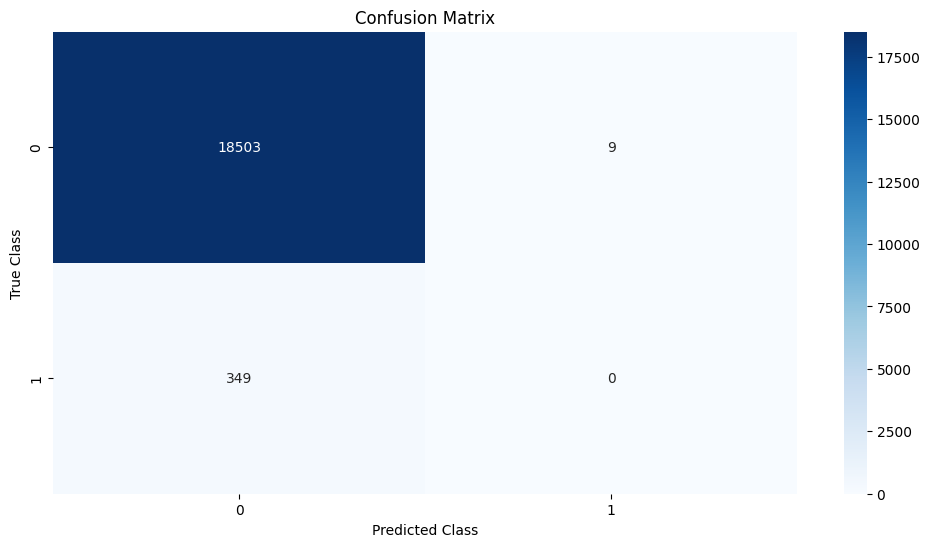

In [66]:
# define max as threshold and calculate metrics
threshold = max
predicted_labels = [1 if error > threshold else 0 for error in reconstruction_errors]
true_labels = scaled_df['reported'].loc[X_test.index].values

# Calculate metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Calculate FPR
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
fpr = fp / (fp + tn)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'False Positive Rate (FPR): {fpr:.4f}')

# heatmap of confusion matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [52]:
# save the model
torch.save(model.state_dict(), '../models/autoencoder_v2.pth')